In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms # Used for common image transformations
import torchvision.datasets as dsets
import torch.utils.data as loader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Let us import the dataset
# transforms.Compose class lets us combine all the transformations
transform=transforms.Compose([transforms.ToTensor(), # ToTensor converts a PIL image to a Tensor
                              transforms.Normalize((0.5,),(0.5,))]) # Normalize normalizes the image to bring all the values in a particular range. (mean,std-dev)

trainset=dsets.MNIST(root='./data', train=True, transform=transform, download=True)
# We dont need to do any transform on targets, so target_transform=False by default.
testset=dsets.MNIST(root='./data', train=False, transform=transform, download=True)
# now create trainloader and testloader
# torch.utils.data.DataLoader is at the heart of pytorch data loading utility
trainloader=loader.DataLoader(dataset=trainset, batch_size=5, shuffle=True, num_workers=0) # batch_size=5 will give 12000 iterations
testloader=loader.DataLoader(dataset=testset, batch_size=1, shuffle=False, num_workers=0) # testing every image in a single batch
classes = ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine')

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [3]:
print(trainloader)
print(testloader)

In [0]:
# Let us define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=10,kernel_size=(3,3),stride=1)
        self.conv2=nn.Conv2d(in_channels=10, out_channels=25, kernel_size=(3,3), stride=1)
        self.fc1=nn.Linear(in_features=25*(5*5),out_features=125)
        self.fc2=nn.Linear(in_features=125, out_features=75)
        self.fc3=nn.Linear(in_features=75, out_features=10)
        self.pool=nn.MaxPool2d(kernel_size=(2,2), stride=2)
    
    def forward(self, x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,25*(5*5))
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net=Net().to(device)
criterion=nn.CrossEntropyLoss() #  taking loss as cross-entropy loss
optimizer=optim.Adam(net.parameters()) # using ADAM as optimizer

In [7]:
# training the network here
lossarr=[]
for epoch in range(12):
    running_loss=0.0
    for i,data in enumerate(trainloader,0): # enumerate(iterable,start)
        inputs,labels=data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs=net(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        if i%2000==1999:
            if i%6000==5999 : print("Epoch:",epoch+1," ,iteration:",i+1," ,loss:",running_loss/2000)
            lossarr.append(running_loss)
            running_loss=0
print("Model trained on 60000 images and 12 epochs.")

Epoch: 1  ,iteration: 6000  ,loss: 0.019517751323365046
Epoch: 1  ,iteration: 12000  ,loss: 0.018480358452196154
Epoch: 2  ,iteration: 6000  ,loss: 0.010589195018041658
Epoch: 2  ,iteration: 12000  ,loss: 0.018704339684250573
Epoch: 3  ,iteration: 6000  ,loss: 0.0225825772932897
Epoch: 3  ,iteration: 12000  ,loss: 0.02047960427413589
Epoch: 4  ,iteration: 6000  ,loss: 0.01720186210537782
Epoch: 4  ,iteration: 12000  ,loss: 0.01708396250797699
Epoch: 5  ,iteration: 6000  ,loss: 0.017342766017490355
Epoch: 5  ,iteration: 12000  ,loss: 0.013920141425007214
Epoch: 6  ,iteration: 6000  ,loss: 0.01878439554236197
Epoch: 6  ,iteration: 12000  ,loss: 0.016720844633892857
Epoch: 7  ,iteration: 6000  ,loss: 0.018180308186680958
Epoch: 7  ,iteration: 12000  ,loss: 0.01686895746904109
Epoch: 8  ,iteration: 6000  ,loss: 0.01790232768518206
Epoch: 8  ,iteration: 12000  ,loss: 0.0133398774732645
Epoch: 9  ,iteration: 6000  ,loss: 0.014354839571483488
Epoch: 9  ,iteration: 12000  ,loss: 0.012264139978

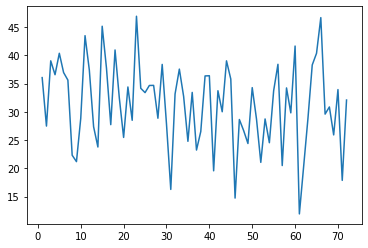

In [8]:
points=np.arange(1,73,1)
plt.plot(points,lossarr)
plt.show()

In [9]:
correct=0
total=0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs=net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print("10000 images tested in total.")
print("Accuracy of network=",correct*100/total)

10000 images tested in total.
Accuracy of network= 99.0


In [0]:
PATH='./mnist_net.pth'
torch.save(net.state_dict(),PATH)